In [30]:
input_path = "input"
output_path = "output"

seed = 0

delivery_days = 313 # 365
scaling = 1.0

earliest_delivery_time = 7
latest_delivery_time = 23

In [31]:
earliest_delivery_time *= 3600.0
latest_delivery_time *= 3600.0

In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import itertools
import scipy.stats as stats
import geopandas as gpd
import os

/home/shoerl/anaconda3/envs/lead_lyon/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
assert os.path.exists("%s/persons.csv" % input_path)
assert os.path.exists("%s/homes.gpkg" % input_path)
assert os.path.exists("%s/activities.csv" % input_path)

# Impute categories to population

In [5]:
df_persons = pd.read_csv("%s/persons.csv" % input_path, sep = ";")
df_persons = df_persons[df_persons["age"] >= 18]

In [6]:
# Age class

df_persons.loc[(df_persons["age"] >= 18) & (df_persons["age"] <= 34), "ac"] = 0 # 18 - 34
df_persons.loc[(df_persons["age"] >= 35) & (df_persons["age"] <= 49), "ac"] = 1 # 35 - 49
df_persons.loc[(df_persons["age"] >= 50) & (df_persons["age"] <= 64), "ac"] = 2 # 50 - 64
df_persons.loc[(df_persons["age"] >= 65), "ac"] = 3 # 65+
df_persons["ac"] = df_persons["ac"].astype(int)

In [7]:
# Socioprofessional class

df_persons.loc[df_persons["socioprofessional_class"].isin([1, 2]), "sc"] = 0 # CE,Artis,Com
df_persons.loc[df_persons["socioprofessional_class"].isin([3]), "sc"] = 1 # Cadre
df_persons.loc[df_persons["socioprofessional_class"].isin([4]), "sc"] = 2 # Prof Int
df_persons.loc[df_persons["socioprofessional_class"].isin([5]), "sc"] = 3 # Employe
df_persons.loc[df_persons["socioprofessional_class"].isin([6]), "sc"] = 4 # Ouvrier
df_persons.loc[df_persons["socioprofessional_class"].isin([7]), "sc"] = 5 # Retraite
df_persons.loc[df_persons["socioprofessional_class"].isin([8]), "sc"] = 6 # Sans Act
df_persons["sc"] = df_persons["sc"].astype(int)

In [8]:
# Household size class

df_household_size = df_persons.groupby("household_id").size().reset_index(name = "household_size")
df_persons = pd.merge(df_persons, df_household_size, on = "household_id")

df_persons.loc[df_persons["household_size"] == 1, "hc"] = 0 # 1
df_persons.loc[df_persons["household_size"] == 2, "hc"] = 1 # 2
df_persons.loc[df_persons["household_size"] == 3, "hc"] = 2 # 3
df_persons.loc[df_persons["household_size"] >= 4, "hc"] = 3 # 4+
df_persons["hc"] = df_persons["hc"].astype(int)

# Obtain marginals from report

In [9]:
# LAD by household size class and socioprofessional class (Figure 29)

marginal_hc_sc = np.array([
    [4, 12, 9, 14, 10, 5, 5],
    [27, 18, 15, 4, 16, 6, 13],
    [24, 26, 22, 6, 12, 10, 22],
    [30, 29, 22, 15, 29, 16, 17],
])

# LAD by age class and socioprofessional class (Figure 30)

marginal_ac_sc = np.array([
    [45, 29, 21, 18, 20, 0, 18],
    [30, 29, 19, 14, 22, 0, 11],
    [14, 17, 10, 5, 16, 12, 9],
    [12, 9, 0, 0, 0, 5, 2],
])

# LAD by socioprofessional class (Table 8)

marginal_sc = np.array([
    23.51, 21.19, 19.08, 15.15, 10.31, 9.77, 6.11
])

# Home delivery by socioprofessional class (Table 8)

probability_home_delivery = np.array([
    53.2, 46.8, 40.7, 49.1, 26.3, 56.5, 70.2
]) * 1e-2

# Total number of orders per year
marginal_total = 14.0

# Sample reference persons and aggregate counts

In [10]:
np.random.seed(seed)

sorter = np.arange(len(df_persons))
np.random.shuffle(sorter)

df_persons = df_persons.iloc[sorter]
df_persons = df_persons.drop_duplicates("household_id")

In [11]:
df = df_persons.groupby([
    "ac", "hc", "sc"
]).size().reset_index(name = "count")

df["weight"] = 1.0

# Apply weighting

In [12]:
for k in tqdm(range(100)): # Run 100 iterations
    
    # Weighting of household size x socioprofessional class
    for hc in range(4):
        for sc in range(7):
            f = (df["hc"] == hc) & (df["sc"] == sc)

            if np.count_nonzero(f) > 0:
                current_weight = (df[f]["weight"] * df[f]["count"]).sum()
                target_weight = marginal_hc_sc[hc, sc] * df[f]["count"].sum()

                if current_weight > 0:
                    factor = target_weight / current_weight
                    df.loc[f, "weight"] *= factor
                    
    # Weighting of household size x socioprofessional class
    for ac in range(4):
        for sc in range(7):
            f = (df["ac"] == ac) & (df["sc"] == sc)

            if np.count_nonzero(f) > 0:
                current_weight = (df[f]["weight"] * df[f]["count"]).sum()
                target_weight = marginal_ac_sc[ac, sc] * df[f]["count"].sum()

                if current_weight > 0:
                    factor = target_weight / current_weight
                    df.loc[f, "weight"] *= factor
    
    # Weighting of socioprofessional class
    for sc in range(7):
        f = df["sc"] == sc

        if np.count_nonzero(f) > 0:
            current_weight = (df[f]["weight"] * df[f]["count"]).sum()
            target_weight = marginal_sc[sc] * df[f]["count"].sum()

            if current_weight > 0:
                factor = target_weight / current_weight
                df.loc[f, "weight"] *= factor
                
    # Weighting of total       
    current_weight = (df["weight"] * df["count"]).sum()
    factor = marginal_total * df["count"].sum() / current_weight
    df["weight"] *= factor

In [13]:
(df["count"] * df["weight"]).sum() / df["count"].sum() # Should be around 14

13.999999999999998

# Generate deliveries

In [14]:
df_deliveries = df_persons[["household_id", "ac", "hc", "sc"]].copy()
df_deliveries = pd.merge(df_deliveries, df)

for sc, ac, hc in itertools.product(range(7), range(4), range(4)):
    f = df_deliveries["sc"] == sc
    f &= df_deliveries["ac"] == ac
    f &= df_deliveries["hc"] == hc
    
    if np.count_nonzero(f) > 0:
        weight = scaling * df_deliveries[f]["weight"].values[0] / delivery_days
        
        df_deliveries.loc[f, "orders"] = stats.poisson(weight).rvs(np.count_nonzero(f))
        df_deliveries.loc[f, "packages"] = stats.poisson(
            weight * probability_home_delivery[sc]).rvs(np.count_nonzero(f))

In [15]:
df_deliveries["orders"].sum() * delivery_days / len(df_deliveries) # Should be around 14

13.966658836623964

In [16]:
df_deliveries["packages"].value_counts()

0.0    1783252
1.0      38166
2.0        616
3.0          8
Name: packages, dtype: int64

In [17]:
df_deliveries = df_deliveries[df_deliveries["packages"] > 0]
df_deliveries[["household_id", "packages"]]

,household_id,packages
10,262463,1.0
22,423110,1.0
28,487448,1.0
32,1534922,1.0
46,680585,1.0
...,...,...
1820526,1821949,1.0
1820807,1008114,1.0
1821612,1345753,1.0
1821908,63990,1.0


# Geographic information

In [18]:
df_spatial = gpd.read_file("%s/homes.gpkg" % input_path)

In [19]:
df_spatial = pd.merge(df_spatial, df_deliveries[["household_id", "packages"]], on = "household_id")
df_spatial.to_file("%s/packages.gpkg" % output_path, driver = "GPKG")

# Possible delivery times

In [20]:
df_deliveries

,household_id,ac,hc,sc,count,weight,orders,packages
10,262463,0,3,3,10215,33.758205,0.0,1.0
22,423110,0,3,3,10215,33.758205,0.0,1.0
28,487448,0,3,3,10215,33.758205,0.0,1.0
32,1534922,0,3,3,10215,33.758205,1.0,1.0
46,680585,0,3,3,10215,33.758205,0.0,1.0
...,...,...,...,...,...,...,...,...
1820526,1821949,3,0,1,1769,5.965565,0.0,1.0
1820807,1008114,3,0,1,1769,5.965565,0.0,1.0
1821612,1345753,3,2,1,161,13.360030,0.0,1.0
1821908,63990,3,3,1,57,14.488899,0.0,1.0


In [32]:
df_activities = pd.read_csv("%s/activities.csv" % input_path, sep = ";")

df_activities = df_activities[
    df_activities["purpose"] == "home"
]

df_activities = df_activities[
    df_activities["household_id"].isin(df_deliveries["household_id"])
]

df_activities["start_time"] = df_activities["start_time"].fillna(0.0)
df_activities["end_time"] = df_activities["end_time"].fillna(30.0 * 3600.0)

In [33]:
df_activities = df_activities[
    df_activities["person_id"].isin(df_persons[df_persons["age"] >= 14]["person_id"].unique())
]

df_activities["start_time"] = np.maximum(df_activities["start_time"], earliest_delivery_time)
df_activities["end_time"] = np.minimum(df_activities["end_time"], latest_delivery_time)

df_activities = df_activities[df_activities["end_time"] - df_activities["start_time"] > 0]

In [34]:
import tqdm.notebook as tqdm

times = np.arange(3 * 4, 27 * 4) * 3600.0 / 4.0
availability = []

for t in tqdm.tqdm(times):
    availability.append(len(df_activities[
        (df_activities["start_time"] <= t) &
        (df_activities["end_time"] > t)
    ].drop_duplicates("household_id")))

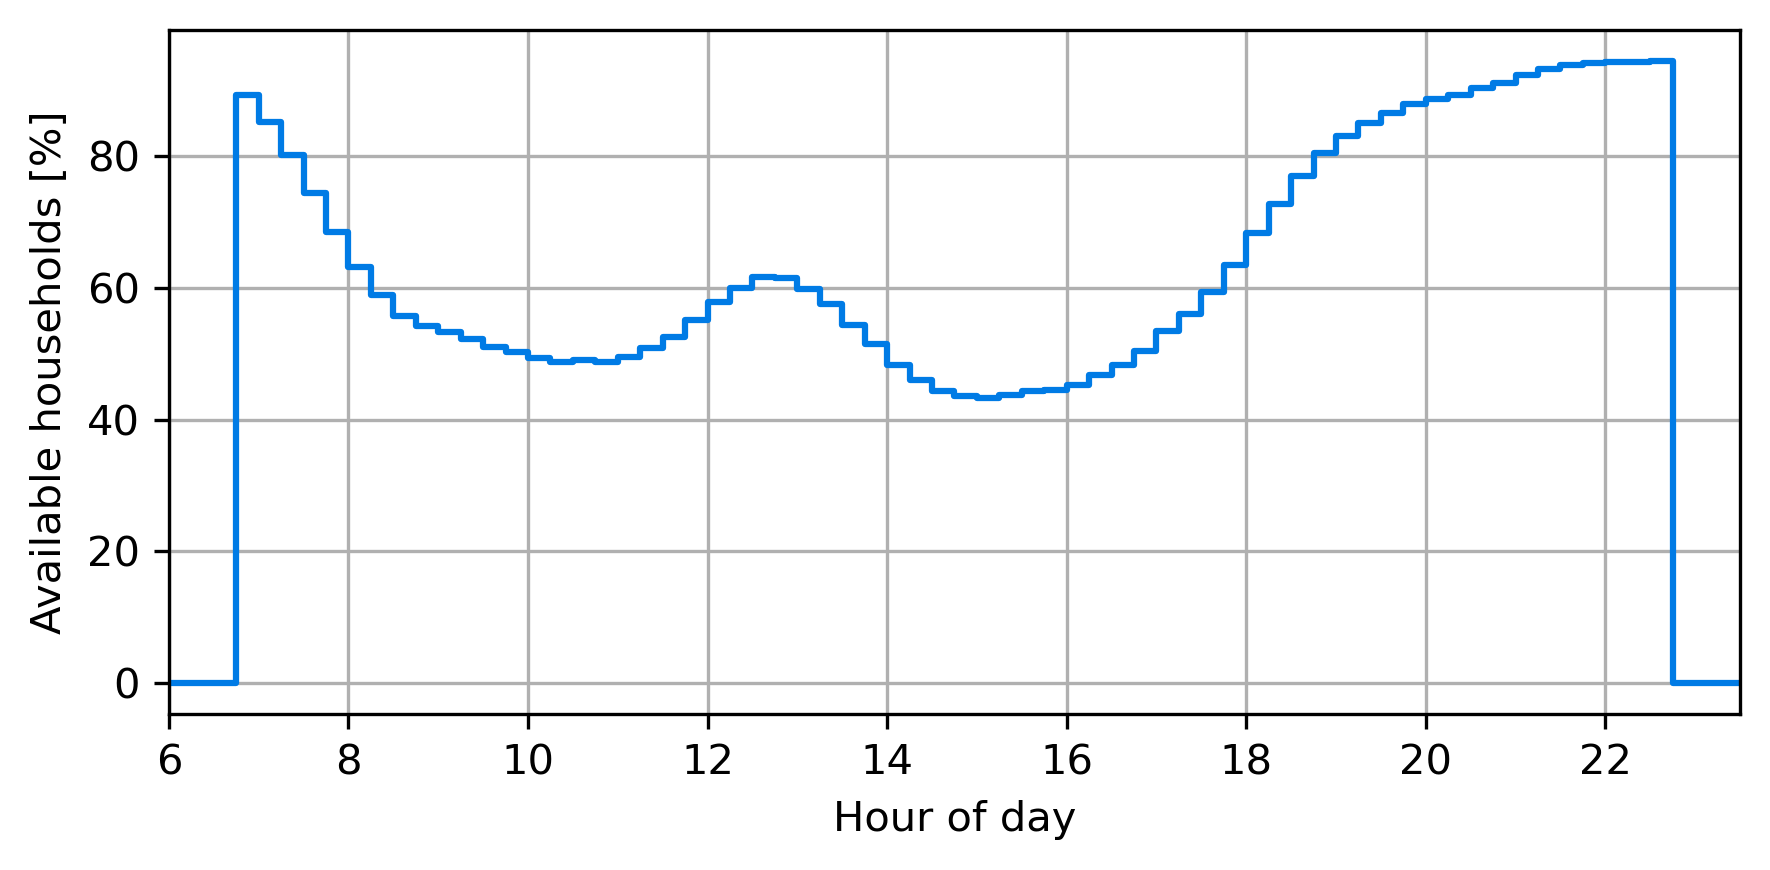

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 3), dpi = 300)

plt.step(
    times / 3600, 100 * np.array(availability) / len(df_deliveries),
    color = "#007be5"
)

plt.xlabel("Hour of day")
plt.xlim([6, 23.5])
plt.ylabel("Available households [%]")

plt.grid()
plt.tight_layout()
plt.savefig("slots.pdf")

In [ ]:
df_slots = df_activities[["household_id", "start_time", "end_time"]]
df_slots = pd.merge(df_spatial, df_slots, on = "household_id")

df_slots["x"] = df_slots["geometry"].x
df_slots["y"] = df_slots["geometry"].y

df_slots = df_slots[["household_id", "start_time", "end_time", "x", "y", "packages"]]

In [ ]:
df_slots.to_csv("%s/slots.csv" % output_path, sep = ";", index = False)

# Plotting

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
%matplotlib inline

In [ ]:
age_class_labels = ["18-34", "35-49", "50-64", "65+"]
sc_class_labels = ["CE/Artis/Com", "Cadre", "Prof Int", "Employé", "Ouvrier", "Retraité", "Sans Act"]
household_size_class_labels = ["1", "3", "3", "4+"]

In [ ]:
plt.figure(figsize = (6, 3), dpi = 300)

plt.bar(
    np.arange(len(marginal_sc)),
    marginal_sc,
    color = "#007be5"
)

plt.gca().set_axisbelow(True)
plt.grid()

plt.gca().xaxis.set_major_locator(tck.FixedLocator(np.arange(7)))
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: sc_class_labels[int(x)]))

plt.xticks(rotation = 45)

plt.ylabel("Purchases per year")

In [ ]:
plt.figure(figsize = (6, 3), dpi = 300)
plt.imshow(marginal_ac_sc, cmap = "Greys")

for i in range(marginal_ac_sc.shape[0]):
    for j in range(marginal_ac_sc.shape[1]):
        color = "k"
        
        if i == 0 and j == 0:
            color = "w"
        
        plt.text(j, i, marginal_ac_sc[i,j], ha = "center", va = "center", color = color)
        
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: k))
        
plt.ylabel("Age class")

plt.gca().xaxis.set_major_locator(tck.FixedLocator(np.arange(7)))
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: sc_class_labels[int(x)]))

plt.gca().yaxis.set_major_locator(tck.FixedLocator(np.arange(4)))
plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: age_class_labels[int(x)]))

plt.xticks(rotation = 45)
plt.ylabel("Age")

plt.title("Purchases per year")

In [ ]:
plt.figure(figsize = (6, 3), dpi = 300)
plt.imshow(marginal_hc_sc, cmap = "Greys")

for i in range(marginal_hc_sc.shape[0]):
    for j in range(marginal_hc_sc.shape[1]):
        color = "k"
        
        if marginal_hc_sc[i,j] > 20:
            color = "w"
        
        plt.text(j, i, marginal_hc_sc[i,j], ha = "center", va = "center", color = color)
        
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: k))
        
plt.ylabel("Household size")

plt.gca().xaxis.set_major_locator(tck.FixedLocator(np.arange(7)))
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: sc_class_labels[int(x)]))

plt.gca().yaxis.set_major_locator(tck.FixedLocator(np.arange(4)))
plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: household_size_class_labels[int(x)]))

plt.xticks(rotation = 45)

plt.title("Purchases per year")

In [ ]:
plt.figure(figsize = (6, 3), dpi = 300)

plt.bar(
    np.arange(len(marginal_sc)),
    probability_home_delivery,
    color = "#007be5"
)

plt.gca().set_axisbelow(True)
plt.grid()

plt.gca().xaxis.set_major_locator(tck.FixedLocator(np.arange(7)))
plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(lambda x, k: sc_class_labels[int(x)]))

plt.xticks(rotation = 45)

plt.ylabel("Home delivery probability")

In [ ]:
# LAD by household size class and socioprofessional class (Figure 29)

marginal_hc_sc = np.array([
    [4, 12, 9, 14, 10, 5, 5],
    [27, 18, 15, 4, 16, 6, 13],
    [24, 26, 22, 6, 12, 10, 22],
    [30, 29, 22, 15, 29, 16, 17],
])

# LAD by age class and socioprofessional class (Figure 30)

marginal_ac_sc = np.array([
    [45, 29, 21, 18, 20, 0, 18],
    [30, 29, 19, 14, 22, 0, 11],
    [14, 17, 10, 5, 16, 12, 9],
    [12, 9, 0, 0, 0, 5, 2],
])

# LAD by socioprofessional class (Table 8)

marginal_sc = np.array([
    23.51, 21.19, 19.08, 15.15, 10.31, 9.77, 6.11
])

# Home delivery by socioprofessional class (Table 8)

probability_home_delivery = np.array([
    53.2, 46.8, 40.7, 49.1, 26.3, 56.5, 70.2
]) * 1e-2

# Total number of orders per year
marginal_total = 14.0